# HW3

### Random Data Generator

- univariate gaussian data

- polynomial basis linear model

### Sqeuential estimate the mean and variance

### Baysian Linear regression

In [1]:
import math
import random
import matplotlib.pyplot as plt
from IPython.display import Latex, Markdown, Pretty
import pandas as pd
import numpy as np

In [2]:
def Mean(x):
    return sum(x) / len(x)

def Variance(x):
    u = Mean(x)
    return sum([(i - u)**2 for i in x]) / len(x)
    
def Covariance(x, y):
    ux = Mean(x)
    uy = Mean(y)
    return sum([(x[i] - ux)*(y[i] - uy) for i in range(len(x))]) / len(x)

class mylogging():
    def __init__(self, output=False, nolog=False):
        self.logs = ""
        self.output = output
        self.nolog = nolog
    
    def info(self, s):
        if self.output:
            print(s)
        if not self.nolog:
            self.logs += s + "\n"

### Random Data Generator

#### univariate gaussian data

- INPUT : expectation value $u$, variance $\sigma^2$
- OUTPUT : one outcome

all outcome will distribute like $N(u,\sigma^2)$

##### Marsaglia polar method

$$ \\
-1 \underline{<} U , V \underline{<} 1, S = U^2+V^2 \\
X = U\sqrt{\frac{-2\ln S}{S}}, Y = V\sqrt{\frac{-2\ln S}{S}}, when \space S < 1
$$

In [3]:
def Marsaglia():
    while True:
        U = random.random()*2-1
        V = random.random()*2-1
        if (U**2)+(V**2) < 1:
            break
    
    S = (U**2)+(V**2)
    S = math.sqrt((-2*math.log(S))/S)
    return (U*S, V*S)

def GaussianDataGenerator(u, v):
    sigma = math.sqrt(v)
    while True:
        D1, D2 = Marsaglia()
        yield u + sigma*D1
        yield u + sigma*D2

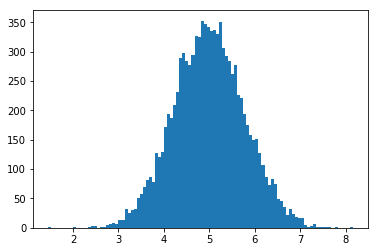

[4.994873342829168, 0.6028041993300499]

In [4]:
GDG = GaussianDataGenerator(5, 0.6)

Gdatas = [next(GDG) for _ in range(10000)]

plt.hist(Gdatas, 100)
plt.show()
[Mean(Gdatas), Variance(Gdatas)]

#### polynomial basis linear model

$$ y=w^TPhi(x)+e;e \sim N(0,\sigma^2) \\
w^TPhi(x) = \sum_{i}^{n} w_ix^i
$$

- INPUT : error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- OUTPUT : one data point $(x,y)$
- NOTE : $ -10.0 < x < 10.0 $

In [5]:
def Gaussian(u, v):
    return lambda x : (math.exp(-1*(((x - u)**2) / (2*v) ) ) / math.sqrt(2*math.pi*v))

def Polynomial(w):
    return lambda x : sum([w[i]*(x**i) for i in range(len(w))])

def PolynomialDataGenerator(n, v, w, x_constrain=(-10,10)):
    if len(w) != n:
        raise TypeError("length of w need equal n, {}!={}".format(len(w), n))
    e = GaussianDataGenerator(u=0,v=v)
    phi = Polynomial(w)
    x_range = abs(x_constrain[0] - x_constrain[1])
    while True:
        x = random.random()*x_range - (x_range/2)
        y = phi(x) + next(e)
        yield (x, y)

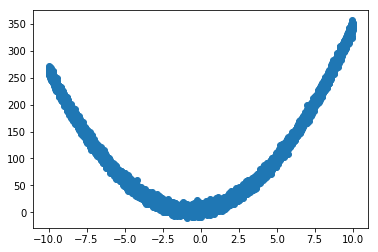

In [6]:
dg = PolynomialDataGenerator(3, 25, [5, 4, 3])
tmp = [next(dg) for _ in range(10000)]
x = [item[0] for item in tmp]
y = [item[1] for item in tmp]

plt.scatter(x, y)
plt.show()

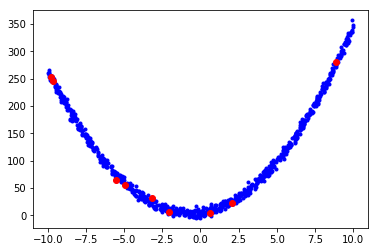

CPU times: user 28.9 s, sys: 21.9 s, total: 50.8 s
Wall time: 17.2 s


In [7]:
%%time
from IPython.display import clear_output
import time 
dg = PolynomialDataGenerator(n=3,v=10000,w=[0,1,0.01])
point_count = 1000
show_per_count = 10
data_x = []
data_y = []
show_x = []
show_y = []
for datapoint in tmp:
    x, y = datapoint
    
    if point_count % show_per_count == 0:
        plt.plot(data_x, data_y, 'b.')
        plt.plot(show_x, show_y, 'ro')
        plt.show()
        #time.sleep(0.5)
        data_x += show_x
        show_x = []
        data_y += show_y
        show_y = []
    else:
        show_x.append(x)
        show_y.append(y)
    
    point_count -= 1
    if point_count == 0:
        break;
    if point_count % show_per_count == 0:
        clear_output(wait=True)

### Sqeuential estimate the mean and variance

- INPUT : expectation value $u$, variance $\sigma^2$
- FUNCTION : find cureent estimates, repeat until the estimates converge
- OUTPUT : print new data point and cureent estimates each iteration

#### Naive algorithm

$$ \\
n = n + 1 \\
\sum x_n = x_n + \sum x_{n-1} \\ 
\sum x_n^2 = x_n^2 + \sum x_{n-1}^2 \\
\overline{x_n} = \frac{\sum x_n}{n} \\
\sigma_n^2 = \frac{\sum x_n^2}{n} - \overline{x_n}^2
$$

#### Welford's online algorithm

$$ \\
\overline{x_n} = \frac{(n-1)\overline{x_{n-1}}+x_n}{n} \\
\sigma_n^2 = \sigma_{n-1}^2 + \frac{(x_n - \overline{x_{n-1}})(x_n - \overline{x_n})-\sigma_{n-1}^2}{n}
$$

In [161]:
def NaiveEstimate():
    u = 0
    v = 1
    n = 0
    data_sum = 0
    data_sum2 = 0
    while True:
        new_data = (yield (u, v))
        n += 1
        data_sum += new_data
        data_sum2 += new_data**2
        u = data_sum / n
        v = (data_sum2 / n) - (u**2)

def WelfordEstimate():
    u = 0
    v = 0
    n = 0
    while True:
        new_data = (yield (u, v))
        n += 1
        next_u = ((n-1)*u + new_data)/n
        v = v + ((new_data - u)*(new_data - next_u) - v)/n
        u = next_u
        
def SqeuentialEstimate(dg, es):
    current_u = 0
    current_v = 1
    es = es()
    current_u, current_v = next(es)
    while True:
        new_data = next(dg)
        current_u, current_v = es.send(new_data)
        yield (new_data, current_u, current_v)

In [209]:
def test_SqeuentialEstimate(u, v, converge_threshold = 10**-3, times=1, max_iter=10000, output=False, output_rate = 1, es=NaiveEstimate):
    iter_counts = []
    errors = []
    dg = GaussianDataGenerator(u, v)
    mylog = mylogging(output)
    
    while times != 0:
        iter_count = 0
        se = SqeuentialEstimate(dg, es=es)
        prev_u = None
        prev_v = None
        test_over = False
        
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for estimate in se:
            iter_count += 1
            new_data, next_u, next_v = estimate
            
            if prev_u != None and prev_v != None:
                if abs(next_u - prev_u) <= converge_threshold and abs(next_v - prev_v) <= converge_threshold:
                    test_over = True

            if iter_count > max_iter and max_iter != -1:
                test_over = True;
            
            error = (next_u - u)**2 + (next_v - v)**2
            if ((iter_count-1) % output_rate == 0 and output_rate > 0) or test_over:
                mylog.info("[{:5d}] new data : {:.3f}\tcurrent(u,v):({:.3f}, {:.3f}), \terror : {:.6f}".format(
                    iter_count,
                    new_data,
                    next_u,
                    next_v,
                    error))
            
            if test_over:
                break;
            
            prev_u = next_u
            prev_v = next_v
                
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        
        iter_counts.append(iter_count)
        errors.append(error)
        
        times -= 1
        
    return (iter_counts, errors, mylog.logs)

In [210]:
_, _, logs = test_SqeuentialEstimate(5, 0.6, converge_threshold=10**-3, times=1, output_rate=100, es=WelfordEstimate)
Pretty(logs)


==========Test Start==========

[    1] new data : 5.791	current(u,v):(5.791, 0.000), 	error : 0.986128
[  101] new data : 4.697	current(u,v):(5.017, 0.600), 	error : 0.000288
[  201] new data : 4.214	current(u,v):(4.983, 0.588), 	error : 0.000447
[  301] new data : 3.509	current(u,v):(4.998, 0.627), 	error : 0.000746
[  401] new data : 6.105	current(u,v):(5.004, 0.602), 	error : 0.000020
[  470] new data : 5.331	current(u,v):(4.976, 0.594), 	error : 0.000606

==========Test   End==========



In [239]:
# test input parameter
test_u = 10
test_v = 10
test_times = 1000
test_converge = 10**-3
test_ess = [NaiveEstimate, WelfordEstimate]

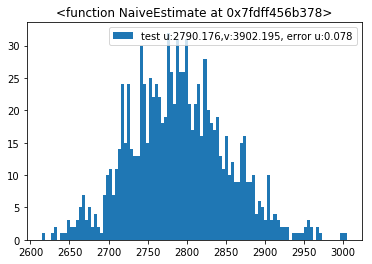

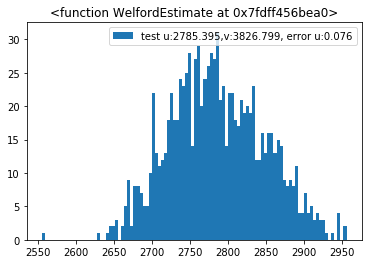

CPU times: user 15.8 s, sys: 547 ms, total: 16.4 s
Wall time: 15.6 s


In [240]:
%%time

for test_es in test_ess:
    test_outputs, test_errors,_ = test_SqeuentialEstimate(es=test_es, u=test_u, v=test_v, converge_threshold=test_converge, times=test_times, output_rate=-1)
    plt.hist(test_outputs, 100, label="test u:{:.3f},v:{:.3f}, error u:{:.3f}".format(Mean(test_outputs), Variance(test_outputs), Mean(test_errors)))
    
    plt.title(str(test_es))
    plt.legend()
    plt.show()

### Baysian Linear regression

- INPUT : for inital prior $\sim N(0, b^{-1}I)$ parameter $b$, error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- FUNCTION : gen one data point and update prior and calculate the predictive distribution, repeat until the posterior converges
- OUTPUT : print the new data point and the current parameter for posterior and predictive distribution

$$\\
k : datapoints \space numbers \\
S^{-1} : prior \space covariance \space matrix , n*n\\
m : prior \space mean \space vector, n*1\\
X : design \space matrix, k*n \\
y_{pred} = Xw + error, k*1 \\
posterior_b = aX^TX + S = aX^TX + prior_b\\
w = posterior_u = posterior_b^{-1}(aX^Ty + Sm) = posterior_b^{-1}(aX^Ty + (prior_b)(prior_u)) \\
$$

#### Predictive distribution

$$ P(Y|\theta) = \int P(Y|w, \theta)P(w, \theta) \sim dw \\
P(Y|w, \theta) \sim N(Y|Xw, a^{-1}) \\
P(w, \theta) = Prior \sim N(W|u, b^{-1}) \\
P(Y|\theta) \sim N(Xw, a^{-1} + XbX^T) \\
$$

In [16]:
from MatrixOP import *
from Polynomial import *

In [112]:
def ShowMatrixByLatex(m):
    latexstr = ""
    
    row = len(m)
    col = len(m[0])
    
    latexstr += r'\begin{bmatrix} '
    
    for i in range(row):
        if i != 0:
            latexstr += r' \\'
        
        for j in range(col):
            if j != 0:
                latexstr += " & "
            
            latexstr += "{:.3f}".format(m[i][j])
        
    
    latexstr += r' \end{bmatrix}'
    
    return "$" + latexstr + "$"

In [17]:
def Design_Matrix(datas, N):
    # create matrix
    Design_X = [];
    Target_y = [];
    
    if type(datas) != list:
        datas = [datas]

    for index, row in enumerate(datas):
        x,y = row
        Design_X.append([basis(x, i) for i in range(N)])
        Target_y.append([y])
    
    return (Design_X,Target_y)

In [18]:
def BaysianLinearRegression(dataGenerator, likelihood_a, prior_u, prior_b):
    n = len(prior_u)
    input_u = prior_u
    input_b = prior_b
    
    
    while True:
        new_data = next(dataGenerator)
        X,y = Design_Matrix(new_data,n)
        
        # b' = aX^TX + b
        posterior_b = mul_matrix_scalar(likelihood_a, mul_matrix(tranpose_matrix(X), X))
        posterior_b = add_matrix(posterior_b, prior_b)
        # u' = b'^-1(aX^Ty + bu)
        posterior_u = add_matrix(mul_matrix_scalar(likelihood_a ,mul_matrix(tranpose_matrix(X), y)), mul_matrix(prior_b, prior_u))
        posterior_u = mul_matrix(inverse_matrix(posterior_b), posterior_u)
        
        reset = yield (new_data, posterior_u, posterior_b)

        if reset == True:
            prior_u = input_u
            prior_b = input_b
            yield (prior_u, prior_b)
        else:
            prior_u = posterior_u
            prior_b = posterior_b

In [231]:
def Design_X(xs, n):
    if type(xs) != list:
        xs = list(x)
    return [[basis(x,i) for i in range(n)] for x in xs]
    
def PredictiveDistribution(a, w, b):
    n = len(w)
    b_i = inverse_matrix(b)
    return lambda x: (mul_matrix(Design_X(x,n),w), add_matrix_scalar((1/a), mul_matrix(mul_matrix(Design_X(x,n), b_i), tranpose_matrix(Design_X(x,n)))) )

def crossAddList(a,b):
    crossList = []
    for z in zip(a,b):
        crossList += [z[0], z[1]]
    return crossList

def ShowPredictiveDistribution(a, w, b, plotline, datas, new_data=None):
    if type(datas) != dict:
        raise TypeError("Type of datas must be hash : {}".format(str(type(datas))))
    if type(plotline) != dict:
        raise TypeError("Type of plotline must be hash : {}".format(str(type(plotline))))
    
    ypd = PredictiveDistribution(a, w, b)
    predict_y, predict_covar = ypd(plotline['x'])
    predict_y = [y[0] for y in predict_y]
    predict_var = [predict_covar[i][i] for i in range(len(predict_covar))]
    predict_var = [math.sqrt(v) for v in predict_var]
    
    clear_output(wait=True)
    
    # many vertical lines
    #plt.plot([plotline['x'],plotline['x']],[list(map(lambda x:x[0]-x[1], zip(predict_y,predict_var))), list(map(lambda x:x[0]+x[1], zip(predict_y,predict_var)))], 'r', linewidth=0.1)
    
    # one line
    plt.plot(crossAddList(plotline['x'] , plotline['x']), crossAddList(list(map(lambda x:x[0]-x[1], zip(predict_y,predict_var))) , list(map(lambda x:x[0]+x[1], zip(predict_y,predict_var)))), 'r', linewidth=0.05)
    plt.plot(datas['x'], datas['y'], 'bo', markerfacecolor='none', label='data points')
    
    plt.plot(plotline['x'], plotline['y'], 'g', label='target')
    plt.plot(plotline['x'], predict_y, 'r', label='predict')
    #plt.plot(plotline['x'], [predict.f(x) for x in plotline['x']], 'r', label='predict')
    
    if new_data:
        plt.plot(new_data['x'], new_data['y'], 'ro', label='new data')
    
    plt.ylim((-2,2))
    plt.legend()
                    
    plt.show()

In [225]:
def test_BaysianLinearRegression(
        BLR, 
        target_equation=None, 
        converge_threshold=10**-3, 
        times=1, 
        max_iter=10000, 
        output=False, 
        output_rate=1,
        x_contrain=(-10,10),
        likelihood_a=1):
    
    iter_counts = []
    plot_x = list(np.linspace(x_contrain[0], x_contrain[1], 500))
    
    if target_equation:
        target_y = [target_equation.f(x) for x in plot_x];
    else:
        target_y = None
    mylog = mylogging(output, False)
    
    
    
    while times != 0:
        iter_count = 0
        data_x = []
        data_y = []
        test_over = False;
        converge_count = 3
        
        # reset BLR
        next(BLR)
        prev_u, prev_b = BLR.send(True)
    
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        # plot
        if target_y:
            ShowPredictiveDistribution(likelihood_a, prev_u, prev_b,{'x':plot_x,'y':target_y},{'x':[],'y':[]})
        
        for regression in BLR:
            iter_count += 1
            x,y = regression[0]
            u = regression[1]
            b = regression[2]
            predict = polynomial_equation(u)
            
            
            # converge check
            All_converge = True
            distance_u = sub_matrix(u, prev_u)
            distance_b = sub_matrix(b, prev_b)
            for rows in distance_u:
                for item in rows:
                    if abs(item) > converge_threshold:
                        All_converge = False
                        break;
                
                if not All_converge:
                    break;
                
            if All_converge:
                converge_count -= 1
            
            if converge_count == 0:
                test_over = True
                
                
            if iter_count >= max_iter and max_iter != -1:
                test_over = True
                
            if (iter_count-1) % output_rate == 0 or test_over:
                mylog.info("[{:5d}] new data(x,y) : ({:.3f}, {:.3f})".format(iter_count, x, y))
                mylog.info("\n predictive equation : " + str(predict) + "\n")
                mylog.info("posterior u : " + ShowMatrixByLatex(u) + "  cov : " + ShowMatrixByLatex(inverse_matrix(b)) + "\n")
                
                # plot
                if target_y:
                    ShowPredictiveDistribution(likelihood_a, u, b,{'x':plot_x,'y':target_y},{'x':data_x,'y':data_y},{'x':x,'y':y})
            
            if test_over:
                break
            
            data_x.append(x)
            data_y.append(y)
                
            prev_u = u;
            prev_b = b;
        
        
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        iter_counts.append(iter_count)
        
        times -= 1
        
    return (iter_counts, mylog.logs)

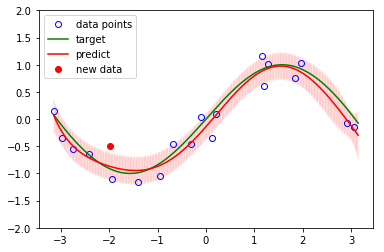

In [232]:
#%%time
# one test data w = [0, 0, 0, 0.01]
# input parameter
error_v = 0.01
w = [0, 1, 0, -1/6,0,1/120,0,-1/5040]
n = 8

# n*n
prior_b = tranpose_matrix(unit_matrix(n=n))
# n*1
prior_u = [[0] for _ in range(n)]
# likelihood gaussian variance
likelihood_a = (10**1)*2
error_v = 1/likelihood_a
x_range = (-math.pi, math.pi)
#x_range = (-10, 10)

dg = PolynomialDataGenerator(n, error_v, w, x_range)
blr = BaysianLinearRegression(dg, likelihood_a, prior_u, prior_b)
target_e = polynomial_equation(w)
_, _ = test_BaysianLinearRegression(blr, target_e,converge_threshold=10**-3,times=1, max_iter=20, output_rate=1, x_contrain=x_range, likelihood_a=likelihood_a)


In [125]:
error_v = 1
w = [5, 4, 3]
n = 3

# n*n
prior_b = tranpose_matrix(unit_matrix(n=n))
# n*1
prior_u = [[0] for _ in range(n)]
# likelihood gaussian variance
likelihood_a = 10**1


dg = PolynomialDataGenerator(n, error_v, w)
blr = BaysianLinearRegression(dg, likelihood_a, prior_u, prior_b)
_, logs = test_BaysianLinearRegression(blr, converge_threshold=10**-2, times=1, max_iter=1000, output_rate=1)
Markdown(logs)


==========Test Start==========

[    1] new data(x,y) : (-3.135, 20.894)

 predictive equation : $$y = +1.91x^2-0.61x^1+0.19$$

posterior u : $\begin{bmatrix} 0.194 \\-0.609 \\1.910 \end{bmatrix}$  cov : $\begin{bmatrix} 0.991 & 0.029 & -0.091 \\0.029 & 0.909 & 0.287 \\-0.091 & 0.287 & 0.102 \end{bmatrix}$

[    2] new data(x,y) : (2.270, 28.901)

 predictive equation : $$y = +3.44x^2+4.42x^1+1.02$$

posterior u : $\begin{bmatrix} 1.020 \\4.419 \\3.435 \end{bmatrix}$  cov : $\begin{bmatrix} 0.967 & -0.116 & -0.136 \\-0.116 & 0.022 & 0.018 \\-0.136 & 0.018 & 0.020 \end{bmatrix}$

[    3] new data(x,y) : (7.075, 181.778)

 predictive equation : $$y = +2.99x^2+4.00x^1+4.03$$

posterior u : $\begin{bmatrix} 4.029 \\4.002 \\2.986 \end{bmatrix}$  cov : $\begin{bmatrix} 0.077 & 0.007 & -0.003 \\0.007 & 0.005 & -0.001 \\-0.003 & -0.001 & 0.000 \end{bmatrix}$

[    4] new data(x,y) : (-2.174, 9.730)

 predictive equation : $$y = +2.99x^2+3.99x^1+4.11$$

posterior u : $\begin{bmatrix} 4.113 \\3.988 \\2.986 \end{bmatrix}$  cov : $\begin{bmatrix} 0.063 & 0.009 & -0.003 \\0.009 & 0.005 & -0.001 \\-0.003 & -0.001 & 0.000 \end{bmatrix}$

[    5] new data(x,y) : (-9.766, 252.236)

 predictive equation : $$y = +3.00x^2+3.91x^1+3.91$$

posterior u : $\begin{bmatrix} 3.914 \\3.910 \\3.004 \end{bmatrix}$  cov : $\begin{bmatrix} 0.037 & -0.001 & -0.001 \\-0.001 & 0.001 & 0.000 \\-0.001 & 0.000 & 0.000 \end{bmatrix}$

[    6] new data(x,y) : (-3.431, 27.357)

 predictive equation : $$y = +3.00x^2+3.88x^1+4.28$$

posterior u : $\begin{bmatrix} 4.276 \\3.879 \\2.998 \end{bmatrix}$  cov : $\begin{bmatrix} 0.029 & -0.000 & -0.000 \\-0.000 & 0.001 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[    7] new data(x,y) : (-6.758, 115.665)

 predictive equation : $$y = +3.00x^2+3.86x^1+4.32$$

posterior u : $\begin{bmatrix} 4.324 \\3.864 \\2.998 \end{bmatrix}$  cov : $\begin{bmatrix} 0.028 & 0.000 & -0.000 \\0.000 & 0.001 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[    8] new data(x,y) : (3.477, 54.808)

 predictive equation : $$y = +3.00x^2+3.88x^1+4.46$$

posterior u : $\begin{bmatrix} 4.464 \\3.881 \\2.998 \end{bmatrix}$  cov : $\begin{bmatrix} 0.024 & -0.000 & -0.000 \\-0.000 & 0.001 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[    9] new data(x,y) : (-1.966, 9.656)

 predictive equation : $$y = +2.99x^2+3.87x^1+4.69$$

posterior u : $\begin{bmatrix} 4.694 \\3.868 \\2.993 \end{bmatrix}$  cov : $\begin{bmatrix} 0.020 & -0.000 & -0.000 \\-0.000 & 0.001 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   10] new data(x,y) : (-4.557, 47.571)

 predictive equation : $$y = +3.00x^2+3.89x^1+4.51$$

posterior u : $\begin{bmatrix} 4.509 \\3.894 \\2.996 \end{bmatrix}$  cov : $\begin{bmatrix} 0.018 & 0.000 & -0.000 \\0.000 & 0.001 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   11] new data(x,y) : (6.826, 169.825)

 predictive equation : $$y = +2.99x^2+3.87x^1+4.49$$

posterior u : $\begin{bmatrix} 4.489 \\3.867 \\2.993 \end{bmatrix}$  cov : $\begin{bmatrix} 0.018 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   12] new data(x,y) : (3.451, 56.487)

 predictive equation : $$y = +2.99x^2+3.90x^1+4.85$$

posterior u : $\begin{bmatrix} 4.850 \\3.903 \\2.990 \end{bmatrix}$  cov : $\begin{bmatrix} 0.016 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   13] new data(x,y) : (2.280, 30.257)

 predictive equation : $$y = +2.99x^2+3.91x^1+4.97$$

posterior u : $\begin{bmatrix} 4.970 \\3.909 \\2.988 \end{bmatrix}$  cov : $\begin{bmatrix} 0.015 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   14] new data(x,y) : (7.928, 224.615)

 predictive equation : $$y = +2.99x^2+3.93x^1+4.94$$

posterior u : $\begin{bmatrix} 4.939 \\3.927 \\2.991 \end{bmatrix}$  cov : $\begin{bmatrix} 0.014 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   15] new data(x,y) : (-7.237, 134.232)

 predictive equation : $$y = +2.99x^2+3.91x^1+4.95$$

posterior u : $\begin{bmatrix} 4.952 \\3.912 \\2.993 \end{bmatrix}$  cov : $\begin{bmatrix} 0.014 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   16] new data(x,y) : (3.553, 57.165)

 predictive equation : $$y = +2.99x^2+3.92x^1+5.00$$

posterior u : $\begin{bmatrix} 5.001 \\3.916 \\2.992 \end{bmatrix}$  cov : $\begin{bmatrix} 0.013 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   17] new data(x,y) : (-3.130, 22.090)

 predictive equation : $$y = +2.99x^2+3.92x^1+5.00$$

posterior u : $\begin{bmatrix} 5.004 \\3.915 \\2.992 \end{bmatrix}$  cov : $\begin{bmatrix} 0.012 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   18] new data(x,y) : (-0.305, 3.574)

 predictive equation : $$y = +2.99x^2+3.92x^1+4.95$$

posterior u : $\begin{bmatrix} 4.948 \\3.916 \\2.993 \end{bmatrix}$  cov : $\begin{bmatrix} 0.011 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   19] new data(x,y) : (6.755, 169.218)

 predictive equation : $$y = +3.00x^2+3.93x^1+4.95$$

posterior u : $\begin{bmatrix} 4.953 \\3.933 \\2.996 \end{bmatrix}$  cov : $\begin{bmatrix} 0.011 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   20] new data(x,y) : (4.903, 93.948)

 predictive equation : $$y = +3.00x^2+3.91x^1+4.84$$

posterior u : $\begin{bmatrix} 4.843 \\3.913 \\2.996 \end{bmatrix}$  cov : $\begin{bmatrix} 0.011 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   21] new data(x,y) : (5.714, 126.576)

 predictive equation : $$y = +3.00x^2+3.93x^1+4.88$$

posterior u : $\begin{bmatrix} 4.883 \\3.928 \\2.997 \end{bmatrix}$  cov : $\begin{bmatrix} 0.011 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   22] new data(x,y) : (7.718, 213.391)

 predictive equation : $$y = +3.00x^2+3.92x^1+4.89$$

posterior u : $\begin{bmatrix} 4.892 \\3.925 \\2.996 \end{bmatrix}$  cov : $\begin{bmatrix} 0.010 & -0.000 & -0.000 \\-0.000 & 0.000 & -0.000 \\-0.000 & -0.000 & 0.000 \end{bmatrix}$

[   23] new data(x,y) : (4.118, 72.480)

 predictive equation : $$y = +3.00x^2+3.93x^1+4.93$$

posterior u : $\begin{bmatrix} 4.929 \\3.928 \\2.995 \end{bmatrix}$  cov : $\begin{bmatrix} 0.010 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$

[   24] new data(x,y) : (-7.264, 135.157)

 predictive equation : $$y = +3.00x^2+3.92x^1+4.93$$

posterior u : $\begin{bmatrix} 4.933 \\3.920 \\2.997 \end{bmatrix}$  cov : $\begin{bmatrix} 0.010 & -0.000 & -0.000 \\-0.000 & 0.000 & 0.000 \\-0.000 & 0.000 & 0.000 \end{bmatrix}$


==========Test   End==========



(array([10.,  8., 11., 13., 23., 18., 10.,  2.,  4.,  1.]),
 array([ 29. ,  39.4,  49.8,  60.2,  70.6,  81. ,  91.4, 101.8, 112.2,
        122.6, 133. ]),
 <a list of 10 Patch objects>)

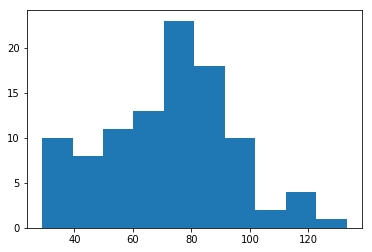

In [127]:
error_v = 1
w = [0, 1, 2, 0.5]
n = 4

# n*n
prior_b = tranpose_matrix(unit_matrix(n=n))
# n*1
prior_u = [[0] for _ in range(n)]
# likelihood gaussian variance
likelihood_a = 10**1


dg = PolynomialDataGenerator(n, error_v, w)
blr = BaysianLinearRegression(dg, likelihood_a, prior_u, prior_b)
outcomes, _ = test_BaysianLinearRegression(blr, converge_threshold=10**-3, times=100, max_iter=1000, output_rate=1001)
plt.hist(outcomes, 10)

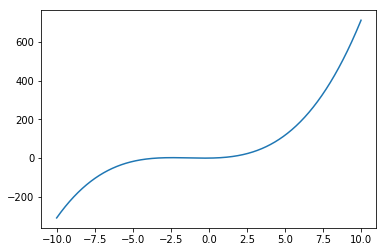

$$y = +0.50x^3+2.01x^2+1.01x^1-0.17$$

In [128]:
_, predict_w, _ = next(blr) 
predict_distribution = polynomial_equation(predict_w)
x = np.linspace(-10,10,1000)
plt.plot(x, [predict_distribution.f(i) for i in x])
plt.show()
Markdown(str(predict_distribution))

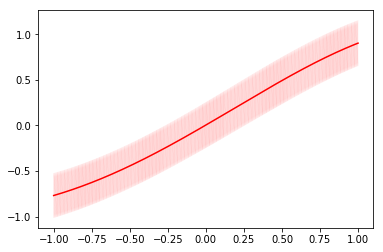

CPU times: user 3.77 s, sys: 243 ms, total: 4.02 s
Wall time: 3.7 s


In [148]:
%%time
_, prior_w, prior_b = next(blr)
ypd = PredictiveDistribution(likelihood_a, prior_w, prior_b)
x = np.linspace(-1,1,1000)
y,covar = ypd(x)
y =[item[0] for item in y]

var = [covar[i][i] for i in range(len(covar))]
var = [math.sqrt(v) for v in var]

# many vertical lines
#plt.plot([x,x],[list(map(lambda x:x[0]-x[1], zip(y,var))), list(map(lambda x:x[0]+x[1], zip(y,var)))], 'r', linewidth=0.05)

# one line
plt.plot(crossAddList(x,x),crossAddList(list(map(lambda x:x[0]-x[1], zip(y,var))), list(map(lambda x:x[0]+x[1], zip(y,var)))), 'r', linewidth=0.025)
plt.plot(x,y,'r')
plt.show()

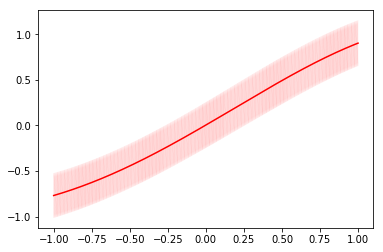

CPU times: user 364 ms, sys: 242 ms, total: 606 ms
Wall time: 244 ms


In [150]:
%%time
# one line
plt.plot(crossAddList(x,x),crossAddList(list(map(lambda x:x[0]-x[1], zip(y,var))), list(map(lambda x:x[0]+x[1], zip(y,var)))), 'r', linewidth=0.025)
plt.plot(x,y,'r')
plt.show()

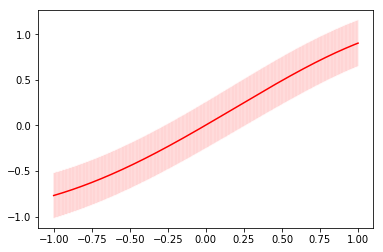

CPU times: user 1.65 s, sys: 204 ms, total: 1.86 s
Wall time: 1.47 s


In [151]:
%%time
# many vertical lines
plt.plot([x,x],[list(map(lambda x:x[0]-x[1], zip(y,var))), list(map(lambda x:x[0]+x[1], zip(y,var)))], 'r', linewidth=0.05)
plt.plot(x,y,'r')
plt.show()